# Product Recognition on Store Shelves
## Computer Vision and Image Processing - Exam Project
### Letizia Mancini, letizia.mancini3@studio.unibo.it

### Introduction:
Object detection techniques based on computer vision can be deployed in super market scenarios for the
creation of a system capable of recognizing products on store shelves.
Given the image of a store shelf, such a system should be able identify the different products present
therein and may be deployed, e.g. to help visually impaired costumers or to automate some common store
management tasks (e.g. detect low in stock or misplaced products).


## Step A - Multiple Product Detection:

Develop an object detection system to identify single instance of products given: one reference image for
each item and a scene image. The system should be able to correctly identify all the product in the shelves
image. One way to solve this task could be the use of **local invariant features**.


### Local Invariant Features Paradigm

Allows to successfully identify objects in scene from a 
single model image per object.

**Four steps**:
1. **Detection**: Identify salient repeatable points (Keypoints) in model and scene images.
2. **Description**: Create a unique description of each point, usually based on its local pixel neighborhood.
3. **Matching**: Match point from scene and model according to a similarity function between the descriptors.
4. **Position Estimation**: Estimate the position of the object in the scene image given enough matching points 

### Environment setup 

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# image directories
scenes_dir = 'scenes'
models_dir = 'models' 
# image names
scenes_name = ['e1.png', 'e2.png', 'e3.png', 'e4.png', 'e5.png']
models_name = ['0.jpg', '1.jpg', '11.jpg', '19.jpg', '24.jpg', '25.jpg', '26.jpg']
# lists
scenes = []
models = []

for i in range( len(scenes_name) ):
    scenes.append(scenes_dir + "/" + scenes_name[i])
print(scenes)

for i in range( len(models_name) ):
    models.append(models_dir + "/" + models_name[i])
print(models)


['scenes/e1.png', 'scenes/e2.png', 'scenes/e3.png', 'scenes/e4.png', 'scenes/e5.png']
['models/0.jpg', 'models/1.jpg', 'models/11.jpg', 'models/19.jpg', 'models/24.jpg', 'models/25.jpg', 'models/26.jpg']


#### Loading the images

In [2]:
img_train = []
img_query = [] 

# load the train images
for img in scenes:
    train = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    img_train.append( train ) # trainImage
# load the query images
for img in models:
    query = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    img_query.append( query ) # queryImage
    

### 1. Keypoint Detection
Common schema:

1. Compute a saliency score for each pixel location based on the response to different mathematical operators. 
2. Keep only the points that are local maxima.
3. For each keypoint estimate the ‘scale’ at which it is salient (scale invariance) and the orientation (rotation invariance).   

Let us now find keypoints in the scene based on the sift detector. We first initialize the SIFT detector object in the following way:

In [3]:
# Creating SIFT object
sift = cv2.xfeatures2d.SIFT_create(nOctaveLayers=5, contrastThreshold=0.1, sigma=1.4) # nOctaveLayers=5, contrastThreshold=0.1, sigma=1.4

Then we need to find keypoints. We will use _detect_ method of the SIFT detector object. Let us find the keypoints of the query images:

In [4]:
# find the keypoints and descriptors with SIFT
kp_query = []

for img in img_query:
    kp_query.append(sift.detect(img))

We can visualize the keypoints

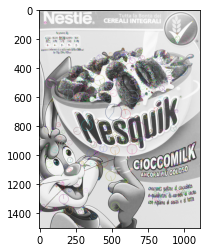

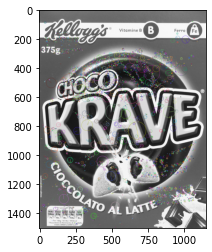

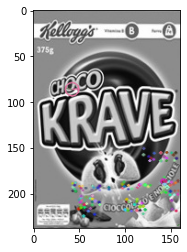

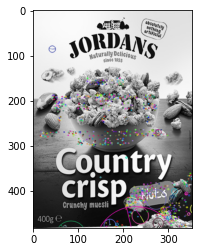

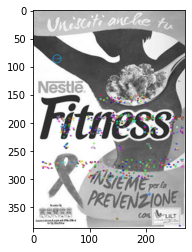

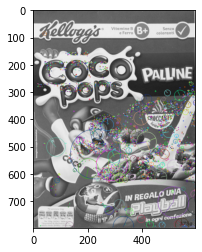

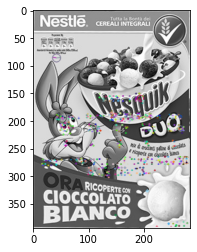

In [5]:
for img in img_query:
    img_visualization = cv2.drawKeypoints(img, kp_query[0], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img_visualization)
    plt.show()

Now, let us find and draw the keypoints for the train images:

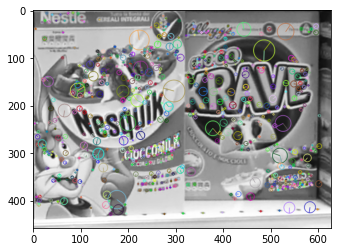

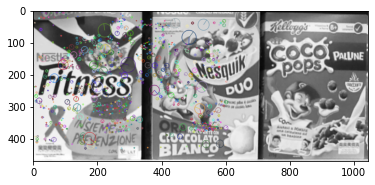

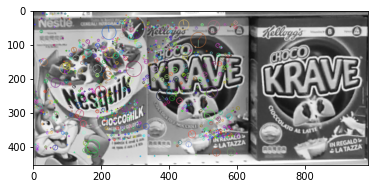

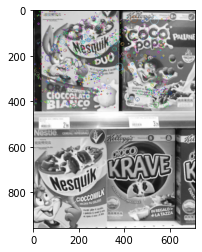

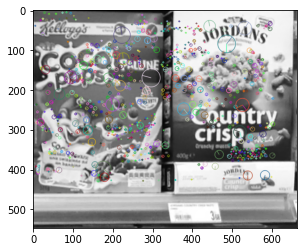

In [6]:
kp_train = []

for img in img_train:
    kp_train.append(sift.detect(img))
    
    img = cv2.drawKeypoints(img, kp_train[0],None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img)
    plt.show()

### 2. Keypoints Description 

Compute for each keypoint a unique description usually based on the nearby pixels (descriptor support).
We will use the SIFT descriptor for this sample study. We can use the same SIFT detector object calling the *compute* method:

In [7]:
# Describing keypoints for query and train images 
## empty array fpr descriptors 
des_query = np.empty(len(img_query), dtype=object)
des_train = np.empty(len(img_train), dtype=object)

for i in range(len(img_query)):
    kp_query[i], des_query[i] = sift.compute(img_query[i], kp_query[i])

for i in range(len(img_train)):
    kp_train[i], des_train[i] = sift.compute(img_train[i], kp_train[i])
    

For each keypoint we got a a 128 floats array SIFT descriptor:

In [8]:
for i in des_train:
    print("Number of query descriptors: ", len(i))
    print("Dimensionality of a SIFT descriptor: ", i[0].shape)
    print("Type of the descriptor: ", i[0].dtype)
    print("\n")

Number of query descriptors:  963
Dimensionality of a SIFT descriptor:  (128,)
Type of the descriptor:  float32


Number of query descriptors:  1197
Dimensionality of a SIFT descriptor:  (128,)
Type of the descriptor:  float32


Number of query descriptors:  1546
Dimensionality of a SIFT descriptor:  (128,)
Type of the descriptor:  float32


Number of query descriptors:  1867
Dimensionality of a SIFT descriptor:  (128,)
Type of the descriptor:  float32


Number of query descriptors:  938
Dimensionality of a SIFT descriptor:  (128,)
Type of the descriptor:  float32




### 3. Feature Matching

Descriptors extracted from the scene are compared with those extracted from the models to find couples of similar ones. 
Classic Nearest Neighbour (NN) Search problem: given a set of $n$ points $R=\{r_0,...,r_n\}$, a query point $q$ and a distance function $D$, find the point $r_{nn} \in R$ such that:

$D(q,r_{nn})<D(q,r_k), \forall r_k \in R$

We will use an approximate kd-tree algorithm from **FLANN** (Fast Library for Approximate Nearest Neighbors) included in OpenCV. 

In [9]:
# Defining index for approximate kdtree algorithm
FLANN_INDEX_KDTREE = 1

# Defining parameters for algorithm 
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

# Defining search params.
# checks=50 specifies the number of times the trees in the index should be recursively traversed.
# Higher values gives better precision, but also takes more time 
search_params = dict(checks = 100) # 100 - 300 - 500 

# Initializing matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching and finding the 2 closest elements for each query descriptor.
# in each scene i search the match for each cereal box
image_matches = np.empty(len(img_train), dtype=object) # img train = scenes
i = 0

# match tra i descrittori delle scene e delle scatole
for des_t in des_train: # for each scene
    image_matches[i] = [] # list to hold the match for each box
    for des_q in des_query: # for each cereal box
        image_matches[i].append(flann.knnMatch(des_q, des_t, k=2))
    i += 1

#### Filtering False Matches in SIFT
To **filter** the matches, Lowe proposed to use a distance ratio test to try to eliminate false matches. 

The **distance ratio** between the two nearest matches of a considered keypoint is computed and it is a good match when this value is below a threshold. 

Indeed, this ratio allows helping to discriminate between **ambiguous matches** (distance ratio between the two nearest neighbors is close to one) and **well discriminated matches**. 
In OpenCV we iterate along all matches checking the distance ratio between the first and the second closest elements using 0.7 as distance ratio threshold:

In [10]:
good = np.empty(len(image_matches), dtype=object)
i = 0

for match_list in image_matches: # for each list of matches related to a scene image
    good[i] = np.empty(len(img_query), dtype=object)
    j = 0
    for matches in match_list: # for each list of matches related to the train image
        good[i][j] = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good[i][j].append(m)
        j += 1
    i += 1

### 4. Position Estimation

We can use  **Random Sample Consensus (RANSAC)**, an algorithm to fit a parametric model to noisy data. In our case estimate an homography from good matches while identifying and discarding the wrong ones.



Images can have different threshold to be recognized: the `check_overlapping` function compute the barycenter of the bounding box points computed with the homography. If they overlap, only the one with the most good points is added to the `dst` (the other gets removed).
Finally, the bounding boxes are drawn.

In [11]:
## utils

class BoundingBox:
    def __init__(self, dst, scene_height, scene_width):
        self.dst = dst
        self.update(scene_height, scene_width) 
        self.centre = dst.mean(axis=0)[0]
        
        self.corners = [(pt[0][0], pt[0][1]) for pt in dst]
        self.h = (self.corners[2][1] + self.corners[1][1] - self.corners[0][1] - self.corners[3][1])/2
        self.w = (self.corners[2][0] + self.corners[3][0] - self.corners[0][0] - self.corners[1][0])/2
        
            
    def update(self, scene_height, scene_width):
        i = 0
        for pt in self.dst:
            x = pt[0][0]
            y = pt[0][1]
            
            # if coordinates out of bound
            if x < 0.0:
                x = 0.0
            elif x > scene_width:
                x = scene_width
            
            if y < 0.0:
                y = 0.0
            elif y > scene_height:
                y = scene_height
            self.dst[i][0] = (x, y)
            i += 1
            

In [13]:
def threshold(pt1, pt2, th):
    dist = np.linalg.norm(pt1 - pt2)
    return dist <= th

def check_overlapping(j, dst, th):
    if j == 0:
        return -1
    
    for i in range(j):
        if dst[i] is not None: # dts[i] list of good points
            if threshold(dst[j].centre, dst[i].centre, th):
                return i
    return -1

In [17]:
# Checking if we found enough matching
MIN_MATCH_COUNT = 80 #80
TH = 10.0
color = (0, 255, 0)

img_train_rgb = [] ## immagini a colori
for img in scenes:
    img_train_rgb.append(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB))
    
# i = index img train
# j = index img query
matchesMask = np.empty(len(img_train), dtype=object)
dst = np.empty(len(img_train), dtype=object)


scene 0

Product 0 - 1 instance found:
	Instance 1 - (163, 216), width: 310 px, height: 431 px 
Product 1 - 1 instance found:
	Instance 1 - (445, 179), width: 296 px, height: 359 px 
Product 2 - 0 instance found:
Product 3 - 0 instance found:
Product 4 - 0 instance found:
Product 5 - 0 instance found:
Product 6 - 0 instance found:


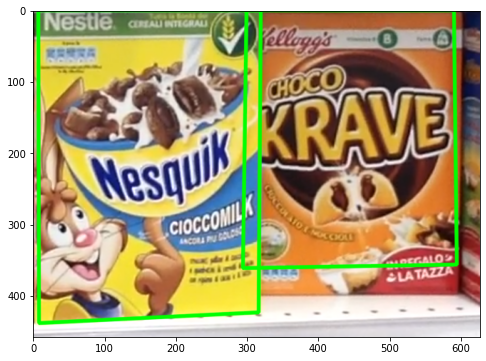



scene 1

Product 0 - 0 instance found:
Product 1 - 0 instance found:
Product 2 - 0 instance found:
Product 3 - 0 instance found:
Product 4 - 1 instance found:
	Instance 1 - (168, 233), width: 334 px, height: 465 px 
Product 5 - 1 instance found:
	Instance 1 - (879, 233), width: 313 px, height: 442 px 
Product 6 - 1 instance found:
	Instance 1 - (538, 231), width: 333 px, height: 462 px 


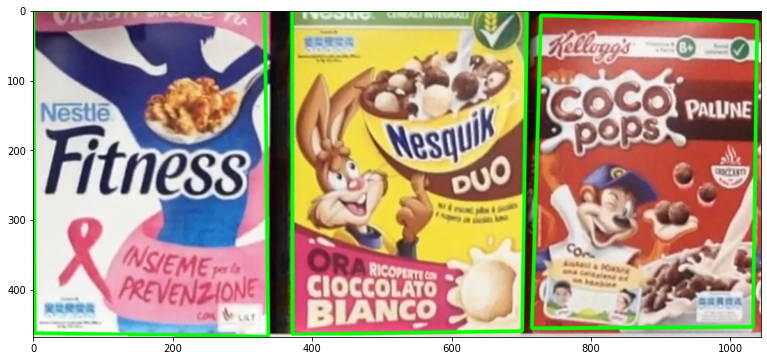



scene 2

Product 0 - 1 instance found:
	Instance 1 - (171, 233), width: 325 px, height: 434 px 
Product 1 - 1 instance found:
	Instance 1 - (818, 198), width: 306 px, height: 396 px 
Product 2 - 1 instance found:
	Instance 1 - (476, 192), width: 301 px, height: 384 px 
Product 3 - 0 instance found:
Product 4 - 0 instance found:
Product 5 - 0 instance found:
Product 6 - 0 instance found:


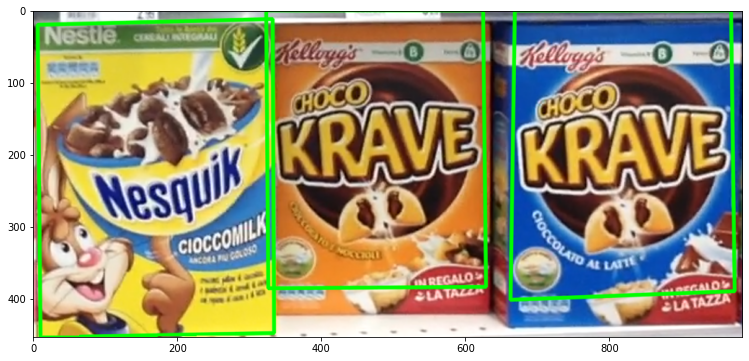



scene 3

Product 0 - 1 instance found:
	Instance 1 - (161, 736), width: 321 px, height: 434 px 
Product 1 - 1 instance found:
	Instance 1 - (465, 689), width: 299 px, height: 390 px 
Product 2 - 0 instance found:
Product 3 - 0 instance found:
Product 4 - 0 instance found:
Product 5 - 1 instance found:
	Instance 1 - (546, 277), width: 330 px, height: 555 px 
Product 6 - 1 instance found:
	Instance 1 - (206, 221), width: 341 px, height: 442 px 


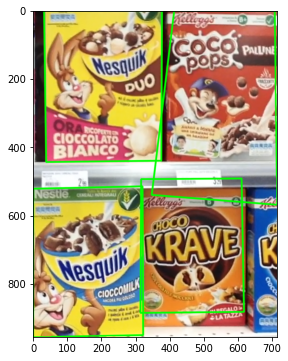



scene 4

Product 0 - 0 instance found:
Product 1 - 0 instance found:
Product 2 - 0 instance found:
Product 3 - 1 instance found:
	Instance 1 - (504, 191), width: 295 px, height: 382 px 
Product 4 - 0 instance found:
Product 5 - 1 instance found:
	Instance 1 - (162, 229), width: 319 px, height: 447 px 
Product 6 - 0 instance found:


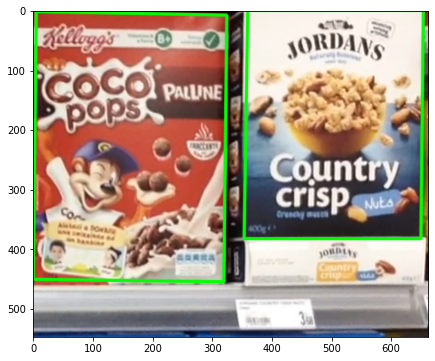

In [18]:
for i in range(len(img_train)):
    
    tmp_kp_train = kp_train[i]
    matchesMask[i] = np.empty(len(img_query), dtype=object)
    dst[i] = np.empty(len(img_query), dtype=object)
    print(f'scene {i}\n')
    for j in range(len(img_query)):
        

        if len(good[i][j]) > MIN_MATCH_COUNT:
            tmp_kp_query = kp_query[j]
            # building the corrspondences arrays of good matches
            src_pts = np.float32([ tmp_kp_query[m.queryIdx].pt for m in good[i][j] ]).reshape(-1,1,2)
            dst_pts = np.float32([ tmp_kp_train[m.trainIdx].pt for m in good[i][j] ]).reshape(-1,1,2)
            # Using RANSAC to estimate a robust homography. 
            # It returns the homography M and a mask for the discarded points
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            # Mask of discarded point used in visualization
            matchesMask[i][j] = mask.ravel().tolist()
            # Corners of the query image
            h,w = img_query[j].shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

            # Projecting the corners into the train image
            out = cv2.perspectiveTransform(pts,M)
            dst[i][j] = BoundingBox(out, img_train[i].shape[0], img_train[i].shape[1])
            
            overlapping = check_overlapping(j, dst[i], TH)
            if overlapping != -1:
                if len(good[i][j]) >= len(good[i][overlapping]):
                    dst[i][overlapping] = None
                else:
                    dst[i][j] = None 
        else:
            # not enough matches found
            matchesMask[i][j] = None

    #### draw the boxes
    for j in range(len(img_query)):
        if dst[i][j] is not None:
            print(f'Product {j} - {1} instance found:')
            
            tmp_box = dst[i][j]
            img_train_rgb[i] = cv2.polylines(img_train_rgb[i], [np.int32(dst[i][j].dst)], True, color, 3, cv2.LINE_AA)
            
            print(f'\tInstance 1 - ({tmp_box.centre[0]:.0f}, {tmp_box.centre[1]:.0f}), width: {tmp_box.w:.0f} px, height: {tmp_box.h:.0f} px ')
        else:
            print(f'Product {j} - {0} instance found:')

    plt.figure(figsize = (40,6))
    plt.imshow(img_train_rgb[i])
    plt.show()
    print("\n")
                      